<a href="https://colab.research.google.com/github/williambiondi/RecommenderGS/blob/main/recommenderGranSasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importazione dei dati e librerie


#Caricamento dati

In [2]:
!pip install tensorflow -q
!pip install transformers -q
!pip install tensorflow-recommenders -q
!pip install keras-tuner -q

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from transformers import DistilBertTokenizer, TFDistilBertModel
from IPython import display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import re
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch


<ipython-input-3-ea52cb71ca94>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
items = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ArticoliGransasso.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ClientiGransasso.csv')
purchases = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/OrdiniGransasso.csv')

In [5]:
items.drop(columns=['Unnamed: 0'], inplace=True)
customers.drop(columns=['Unnamed: 0'], inplace=True)
purchases.drop(columns=['Unnamed: 0'], inplace=True)

#Preparazione dati per modello


Annoto come interazione positiva (1) tutti gli articoli acquistati, come interazione negativa (-1) tutti gli articoli rimborsati

In [6]:
interactions = [1 if row['RefundedEUR'] == 0 else 0 for _,row in purchases.iterrows()]
purchases["Interaction"] = interactions

In [7]:
text_combined = []
for idx, row in items.iterrows():
  descriptive = row['ItemName'].lower()+" "+row['Description']
  text_combined.append(descriptive)
items['TextInfo'] = text_combined

In [8]:
len_desc = [len(row['TextInfo'].split(" ")) for _,row in items.iterrows()]
max(len_desc)

190

In [9]:
#items = items[items['Availability']==1].reset_index()

Utilizzo DistilBERT per ottenere gli embeddings di tutta l'informazione testuale degli articoli (nome articolo e descrizione)

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
enc_input = tokenizer(items['TextInfo'].tolist(),
                      padding=True,
                      truncation=True,
                      max_length=150,
                      return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [12]:
with tf.device('/CPU:0'):
  outputs = distilbert_model(enc_input)
  embeddings = outputs.last_hidden_state

In [13]:
embeddings_np = embeddings.numpy()
summary_embeddings = embeddings_np[:,0,:]
df_embeddings = pd.DataFrame(summary_embeddings)
df_embeddings.columns = [f'embedding_{i}' for i in range(df_embeddings.shape[1])]

In [14]:
df_embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.152692,-0.702594,0.226576,-0.092627,0.150878,-0.052346,0.132293,0.289687,-0.130669,-0.294651,...,-0.045851,-0.592888,0.098133,-0.310700,0.045292,-0.331142,-0.110403,-0.167462,0.064619,-0.084191
1,-0.183465,-0.758047,0.025607,-0.106879,0.167659,-0.116864,0.084983,0.325271,0.031012,-0.256441,...,-0.039702,-0.501641,0.018874,-0.313824,0.023122,-0.488100,-0.089356,-0.199527,0.250173,-0.131353
2,-0.235759,-0.616278,0.186698,-0.050991,0.163522,-0.045681,0.081499,0.254824,-0.088808,-0.285371,...,0.009386,-0.555698,0.095906,-0.385060,-0.018019,-0.202692,-0.129432,-0.250053,0.047501,-0.117531
3,-0.080284,-0.587355,0.281824,-0.119877,0.063588,-0.044179,0.075656,0.288735,-0.159558,-0.265397,...,0.126247,-0.505958,0.169416,-0.327713,0.025113,-0.154299,-0.163061,-0.110773,0.150633,0.053784
4,-0.136119,-0.455886,0.220127,-0.032341,0.044970,-0.166100,0.079893,0.324760,-0.202329,-0.267275,...,-0.074009,-0.526029,0.137117,-0.344637,-0.017099,-0.273234,-0.202651,-0.110191,0.116088,0.078280


#PCA

Riduco gli embeddings

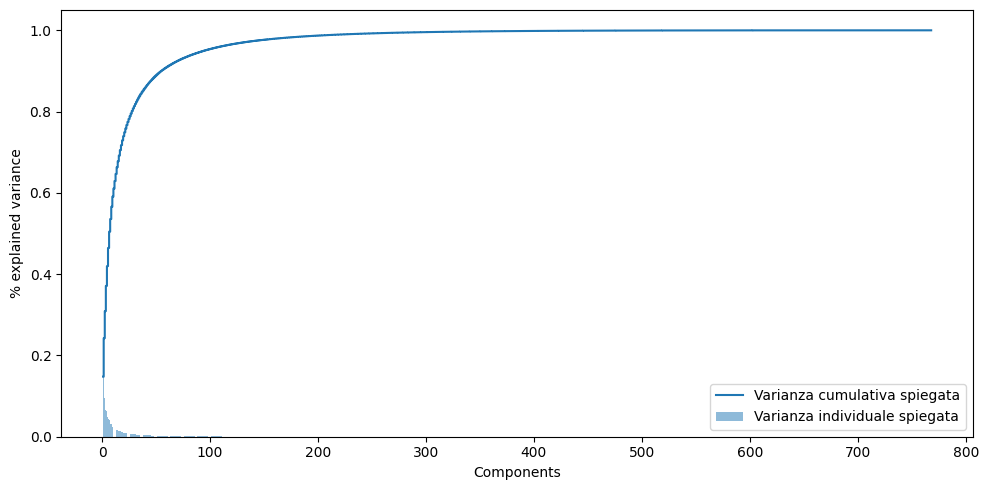

In [ ]:
pca = PCA()
pca.fit(df_embeddings)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

n_components = np.where(cumulative>=0.95)[0][0]+1

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center', label='Varianza individuale spiegata')
plt.step(range(1, len(cumulative) + 1), cumulative, where='mid', label='Varianza cumulativa spiegata')
plt.ylabel('% explained variance')
plt.xlabel('Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(df_embeddings)
df_reduced = pd.DataFrame(reduced, columns = [f"pc_{i}" for i in range(reduced.shape[1])])

In [ ]:
df_reduced['ItemId'] = items['ItemId']

In [ ]:
df_reduced.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_86,pc_87,pc_88,pc_89,pc_90,pc_91,pc_92,pc_93,pc_94,ItemId
0,0.432970,-0.214806,-0.676683,0.242818,-0.502649,0.213220,0.044391,-0.406389,0.119929,0.290795,...,0.056196,-0.075866,0.059007,-0.040150,0.103424,0.022511,-0.062532,-0.008932,0.036174,0
1,-1.344923,-0.502456,-0.108875,-0.200827,-0.811736,-0.145801,-0.138471,-0.102809,0.132498,-0.286610,...,-0.084468,0.040849,-0.116503,-0.068888,0.126376,0.072122,0.097351,-0.026363,0.077163,1
2,-0.508014,0.428694,-0.924211,-0.456853,-0.142499,-0.227780,0.160290,0.145653,-0.215662,-0.172427,...,-0.073623,-0.090369,0.068430,-0.078839,-0.051480,-0.004852,0.045254,0.000644,-0.035522,2
3,0.467723,0.633642,-0.853467,0.216090,-0.056622,-0.370798,-0.207283,0.360090,0.606439,0.535531,...,0.116651,-0.116166,-0.030867,0.016824,0.250133,0.056755,0.072139,0.063508,0.121616,3
4,1.449940,0.353150,-0.104016,-0.192967,-0.214779,-0.368194,-0.541566,0.426434,0.140475,0.117268,...,0.056094,-0.070079,-0.078324,-0.028312,0.021881,0.077104,-0.071455,0.095920,0.033813,4


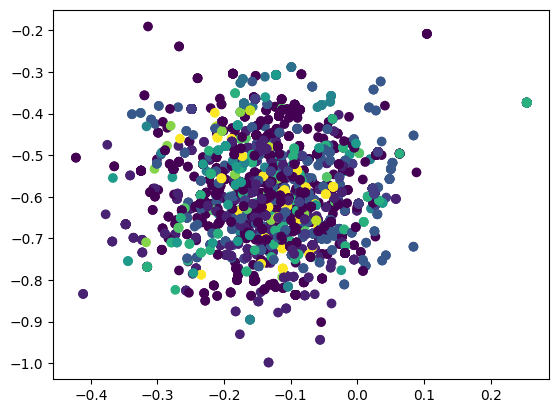

In [ ]:
plt.scatter(df_embeddings.iloc[:,0], df_embeddings.iloc[:,1], c =c)

In [ ]:
items.shape

(3497, 13)

In [ ]:
df_reduced.shape

(3497, 96)

In [ ]:
import json
def try_catch(fn, *args):
  try:
    return fn(*args)
  except:
    return ' '
cats = items.Category.apply(lambda x: try_catch(eval,x)[0])
unique = cats.unique().tolist()
c = [unique.index(_) for _ in cats]

In [ ]:
df_embeddings['ItemId'] = items['ItemId']

In [ ]:
full_items = items.merge(df_reduced, on='ItemId')

In [ ]:
df_full = full_items.merge(purchases, on='ItemId')

In [ ]:
df_full

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,...,embedding_764,embedding_765,embedding_766,embedding_767,Id,UserId,CreatedOnUtc,RefundedEUR,UnitPriceTaxEUR,Interaction
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,8812,0,2021-01-01 09:29:05.2513839,0.0,130.0,1
1,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,8860,47,2021-01-03 23:11:34.9635880,0.0,130.0,1
2,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,9311,413,2021-02-13 12:39:33.7391675,0.0,130.0,1
3,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,9772,276,2021-04-10 11:33:22.9952881,0.0,130.0,1
4,A20201312414230005,WAVE PATTERN TURTLENECK,['Maglieria'],160.0,1,Fall-Winter,0,5,Men,turtleneck sweater in pure merino wool embelli...,...,-0.089355,-0.199527,0.250173,-0.131352,8813,1,2021-01-01 09:39:57.3829465,0.0,160.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19867,A20231312622601465,AIR WOOL TURTLE NECK,['Maglieria'],200.0,3492,Fall-Winter,1,465,Men,air wool turtleneck the special feature of thi...,...,-0.190599,-0.120545,0.153098,0.118914,19639,956,2023-10-30 09:41:32.5978041,0.0,200.0,1
19868,A20231312622601661,AIR WOOL TURTLE NECK,['Maglieria'],200.0,3493,Fall-Winter,1,661,Men,air wool turtleneck the special feature of thi...,...,-0.190599,-0.120545,0.153098,0.118914,19639,956,2023-10-30 09:41:32.5978041,0.0,200.0,1
19869,A20232311825022098,WOOL JACKET WITH ECO-PADDING,"['Capispalla', 'Maglieria']",460.0,3494,Fall-Winter,1,98,Men,super geelong wool bomber jacket the front is ...,...,-0.227826,-0.067119,0.025371,-0.009382,19640,5242,2023-10-30 13:38:18.8120889,1400.0,460.0,-1
19870,A20232312519621039,2-PLY CASHMERE BLEND MOCK ZIP,['Maglieria'],245.0,3495,Fall-Winter,1,39,Men,2ply mock zip sweater cashmere blend an evergr...,...,-0.088379,-0.283592,0.293171,-0.085258,19640,5242,2023-10-30 13:38:18.8120889,1400.0,245.0,-1


#Training w/o PCA

In [15]:
df_embeddings['ItemId'] = items['ItemId']
full_items = items.merge(df_embeddings, on='ItemId')
df_full = full_items.merge(purchases, on='ItemId')

In [19]:
#user_id_mapping = {old_id: new_id for new_id, old_id in enumerate(df_full['UserId'].unique())}
#df_full['UserId'] = df_full['UserId'].map(user_id_mapping)

In [16]:
data_tf = tf.data.Dataset.from_tensor_slices({
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "item_id": df_full['ItemId'].values.reshape(-1,1),
    "item_embedding" : df_full[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values,
    "interaction" : df_full['Interaction'].values.reshape(-1,1)
})
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values
})
candidates_ds = candidates_tf.batch(32)

In [17]:
data_tf = data_tf.shuffle(buffer_size=1024, seed = 999, reshuffle_each_iteration = False)
full_size = len(data_tf)
train_size = int(full_size * 0.8)
val_size = int(train_size * 0.2)
train_size -= val_size

train = data_tf.take(train_size)
rest = data_tf.skip(train_size)
val = rest.take(val_size)
test = rest.skip(val_size)

In [18]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [19]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, features, training = False):
    user_emb = self.user_model(features['user_id'])
    item_emb = self.item_model(features['item_embedding'])
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = features['interaction'], predictions = predictions)
    return retrieval_loss + ranking_loss

In [20]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_embeddings.shape[1] - 1

user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Flatten()
                                  ])

item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(6)
                                ])

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 20,
                                              restore_best_weights=True)

In [22]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [23]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


398/398 [==============================] - 60s 138ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0175 - factorized_top_k/top_5_categorical_accuracy: 0.0233 - factorized_top_k/top_10_categorical_accuracy: 0.0259 - factorized_top_k/top_50_categorical_accuracy: 0.0565 - factorized_top_k/top_100_categorical_accuracy: 0.0842 - binary_accuracy: 0.7306 - loss: 110.9966 - regularization_loss: 0.0000e+00 - total_loss: 110.9966 - val_factorized_top_k/top_1_categorical_accuracy: 0.0013 - val_factorized_top_k/top_5_categorical_accuracy: 0.0025 - val_factorized_top_k/top_10_categorical_accuracy: 0.0028 - val_factorized_top_k/top_50_categorical_accuracy: 0.0343 - val_factorized_top_k/top_100_categorical_accuracy: 0.0532 - val_binary_accuracy: 0.8028 - val_loss: 24.4435 - val_regularization_loss: 0.0000e+00 - val_total_loss: 24.4435
Epoch 2/100
398/398 [==============================] - 56s 140ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0300 - factorized_top_k/top_5_categorical

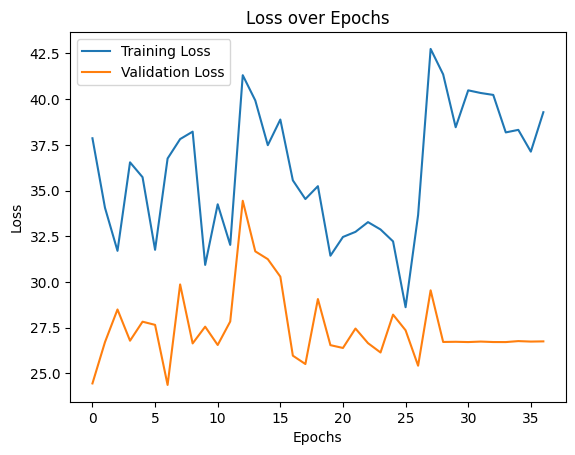

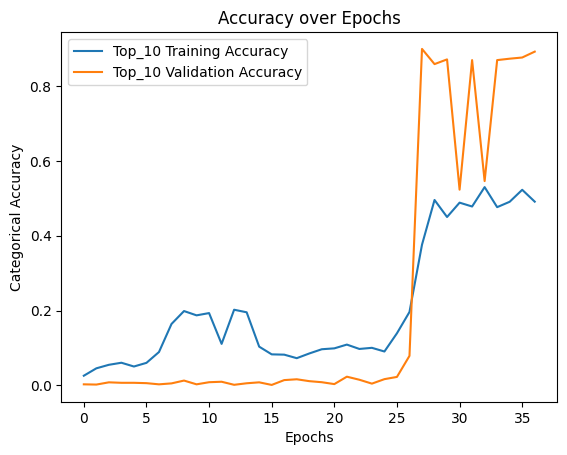

In [24]:
metrics = history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotta l'accuracy di training
plt.plot(metrics['factorized_top_k/top_10_categorical_accuracy'], label='Top_10 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_10_categorical_accuracy'], label='Top_10 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

#Training with PCA

In [ ]:
data_tf = tf.data.Dataset.from_tensor_slices({
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "item_id": df_full['ItemId'].values.reshape(-1,1),
    "item_embedding" : df_full[[f'pc_{i}' for i in range(reduced.shape[1])]].values
})

In [ ]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'pc_{i}' for i in range(reduced.shape[1])]].values
})
candidates_ds = candidates_tf.batch(32)

Divido in train e test

In [ ]:
data_tf = data_tf.shuffle(buffer_size=1024, seed = 999, reshuffle_each_iteration = False)
full_size = len(data_tf)
train_size = int(full_size * 0.8)
val_size = int(train_size * 0.2)
train_size -= val_size

train = data_tf.take(train_size)
rest = data_tf.skip(train_size)
val = rest.take(val_size)
test = rest.skip(val_size)

In [ ]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [ ]:
for features in train.take(1):
    print("User ID Shape in Train:", features["user_id"].shape)
    print("Item Embedding Shape in Train:", features["item_embedding"].shape)

User ID Shape in Train: (32, 1)
Item Embedding Shape in Train: (32, 95)


In [ ]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))

  def compute_loss(self, features, training = False):
    user_emb = self.user_model(features['user_id'])
    item_emb = self.item_model(features['item_embedding'])
    return self.task(user_emb, item_emb)

In [ ]:
n_components

95

In [ ]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = n_components

user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  tf.keras.layers.Flatten(),

                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.Flatten(),
                                  ])

item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(6),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dense(6)
                                ])

In [ ]:
df_full

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,...,pc_91,pc_92,pc_93,pc_94,Id,UserId,CreatedOnUtc,RefundedEUR,UnitPriceTaxEUR,Interaction
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.022511,-0.062532,-0.008932,0.036174,8812,0,2021-01-01 09:29:05.2513839,0.0,130.0,1
1,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.022511,-0.062532,-0.008932,0.036174,8860,47,2021-01-03 23:11:34.9635880,0.0,130.0,1
2,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.022511,-0.062532,-0.008932,0.036174,9311,413,2021-02-13 12:39:33.7391675,0.0,130.0,1
3,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.022511,-0.062532,-0.008932,0.036174,9772,276,2021-04-10 11:33:22.9952881,0.0,130.0,1
4,A20201312414230005,WAVE PATTERN TURTLENECK,['Maglieria'],160.0,1,Fall-Winter,0,5,Men,turtleneck sweater in pure merino wool embelli...,...,0.072122,0.097351,-0.026363,0.077163,8813,1,2021-01-01 09:39:57.3829465,0.0,160.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19867,A20231312622601465,AIR WOOL TURTLE NECK,['Maglieria'],200.0,3492,Fall-Winter,1,465,Men,air wool turtleneck the special feature of thi...,...,0.055305,-0.089542,0.009496,0.016985,19639,956,2023-10-30 09:41:32.5978041,0.0,200.0,1
19868,A20231312622601661,AIR WOOL TURTLE NECK,['Maglieria'],200.0,3493,Fall-Winter,1,661,Men,air wool turtleneck the special feature of thi...,...,0.055305,-0.089542,0.009496,0.016985,19639,956,2023-10-30 09:41:32.5978041,0.0,200.0,1
19869,A20232311825022098,WOOL JACKET WITH ECO-PADDING,"['Capispalla', 'Maglieria']",460.0,3494,Fall-Winter,1,98,Men,super geelong wool bomber jacket the front is ...,...,0.013882,-0.082032,-0.009291,0.038633,19640,5242,2023-10-30 13:38:18.8120889,1400.0,460.0,-1
19870,A20232312519621039,2-PLY CASHMERE BLEND MOCK ZIP,['Maglieria'],245.0,3495,Fall-Winter,1,39,Men,2ply mock zip sweater cashmere blend an evergr...,...,0.024099,0.041700,0.015320,0.000943,19640,5242,2023-10-30 13:38:18.8120889,1400.0,245.0,-1


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_factorized_top_k/top_100_categorical_accuracy', patience=10, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model',
    save_best_only=True,
    monitor='val_loss',
    mode='min')

In [ ]:
initial_learning_rate = 0.5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)

In [ ]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)

In [ ]:
history = recommender.fit(train,
                validation_data = val,
                epochs=100)

Epoch 1/100
398/398 [==============================] - 36s 91ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0506 - factorized_top_k/top_5_categorical_accuracy: 0.0532 - factorized_top_k/top_10_categorical_accuracy: 0.0578 - factorized_top_k/top_50_categorical_accuracy: 0.0972 - factorized_top_k/top_100_categorical_accuracy: 0.1470 - loss: 95.6810 - regularization_loss: 0.0000e+00 - total_loss: 95.6810 - val_factorized_top_k/top_1_categorical_accuracy: 0.0456 - val_factorized_top_k/top_5_categorical_accuracy: 0.0462 - val_factorized_top_k/top_10_categorical_accuracy: 0.0478 - val_factorized_top_k/top_50_categorical_accuracy: 0.0591 - val_factorized_top_k/top_100_categorical_accuracy: 0.0859 - val_loss: 27.2782 - val_regularization_loss: 0.0000e+00 - val_total_loss: 27.2782
Epoch 2/100
398/398 [==============================] - 36s 91ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0549 - factorized_top_k/top_5_categorical_accuracy: 0.0578 - factorized_top_k/top_10_cate

In [ ]:
metrics = history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotta l'accuracy di training
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
recommender.evaluate(test)

125/125 [==============================] - 9s 71ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0101 - factorized_top_k/top_5_categorical_accuracy: 0.0133 - factorized_top_k/top_10_categorical_accuracy: 0.0199 - factorized_top_k/top_50_categorical_accuracy: 0.0282 - factorized_top_k/top_100_categorical_accuracy: 0.0410 - loss: 180.6875 - regularization_loss: 0.0000e+00 - total_loss: 180.6875


[0.01006289292126894,
 0.013333333656191826,
 0.01987421326339245,
 0.02817610092461109,
 0.041006289422512054,
 69.03236389160156,
 0,
 69.03236389160156]

#Tuning dei parametri

In [52]:
class HyperRecommender(HyperModel):
  def __init__(self, user_input_dim, item_input_dim, embedding_dim, candidates_ds):
    self.user_input_dim = user_input_dim
    self.item_input_dim = item_input_dim
    self.embedding_dim = embedding_dim
    self.candidates_ds = candidates_ds

  def build(self, hp):
    unique_user_ids = df_full['UserId'].unique().astype(str)
    unique_item_ids = df_full['ItemId'].unique().astype(str)
    embedding_dim = df_embeddings.shape[1]-1
    user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Flatten(),
                                  ])
    item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2))
                                ])

    # Define the CFRecommender model
    model = CFRecommender(user_model, item_model, self.candidates_ds)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=6e-2, sampling='LOG')),
    )

    return model

In [53]:
hypermodel = HyperRecommender(user_input_dim = len(unique_user_ids),
                              item_input_dim = embedding_dim,
                              embedding_dim = embedding_dim,
                              candidates_ds = candidates_ds)


In [55]:
tuner = RandomSearch(hypermodel,
                     objective = 'val_loss',
                     max_trials = 50,
                     directory = 'keras_tuner_dir',
                     project_name = 'gs_recommender')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
tuner.search_space_summary()
tuner.search(train, validation_data=val, epochs=20)
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
for hparam in best_hyperparams.values:
  print(f'{hparam}: {best_hyperparams.get(hparam)}')

Trial 49 Complete [00h 19m 40s]
val_loss: 26.628984451293945

Best val_loss So Far: 22.390087127685547
Total elapsed time: 15h 36m 14s

Search: Running Trial #50

Value             |Best Value So Far |Hyperparameter
32                |32                |dense_size
0.4               |0.05              |dropout_rate
0.00036674        |0.0041061         |learning_rate

Epoch 1/20
398/398 [==============================] - 61s 149ms/step - factorized_top_k/top_1_categorical_accuracy: 3.1451e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0010 - factorized_top_k/top_10_categorical_accuracy: 0.0021 - factorized_top_k/top_50_categorical_accuracy: 0.0170 - factorized_top_k/top_100_categorical_accuracy: 0.0359 - binary_accuracy: 0.7246 - loss: 111.0723 - regularization_loss: 0.0000e+00 - total_loss: 111.0723 - val_factorized_top_k/top_1_categorical_accuracy: 0.0038 - val_factorized_top_k/top_5_categorical_accuracy: 0.0069 - val_factorized_top_k/top_10_categorical_accuracy: 0.0091 - val_fac

In [57]:
best_model = tuner.hypermodel.build(best_hyperparams)
best_history = best_model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
398/398 [==============================] - 62s 152ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0149 - factorized_top_k/top_5_categorical_accuracy: 0.0196 - factorized_top_k/top_10_categorical_accuracy: 0.0243 - factorized_top_k/top_50_categorical_accuracy: 0.0572 - factorized_top_k/top_100_categorical_accuracy: 0.0933 - binary_accuracy: 0.7798 - loss: 109.5902 - regularization_loss: 0.0000e+00 - total_loss: 109.5902 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 3.1456e-04 - val_factorized_top_k/top_10_categorical_accuracy: 3.1456e-04 - val_factorized_top_k/top_50_categorical_accuracy: 0.0116 - val_factorized_top_k/top_100_categorical_accuracy: 0.0377 - val_binary_accuracy: 0.8119 - val_loss: 33.5852 - val_regularization_loss: 0.0000e+00 - val_total_loss: 33.5852
Epoch 2/100
398/398 [==============================] - 59s 149ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0208 - factorized

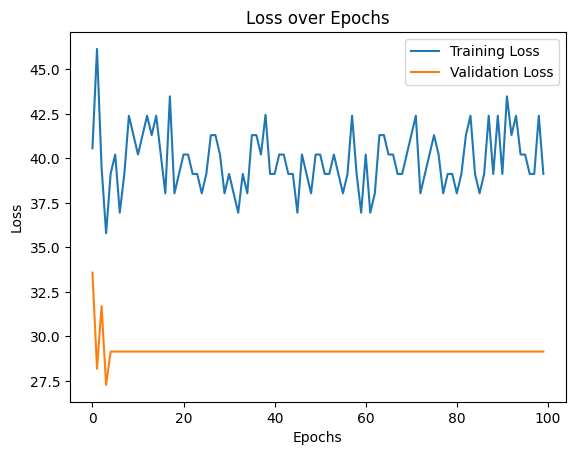

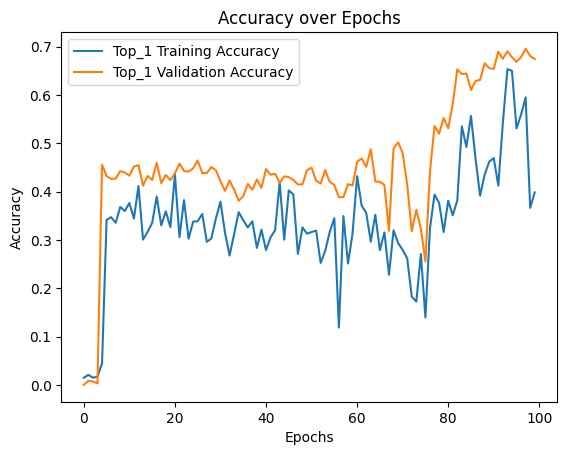

In [58]:
metrics = best_history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotta l'accuracy di training
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
recommender.evaluate(test)

125/125 [==============================] - 14s 114ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.1361 - factorized_top_k/top_10_categorical_accuracy: 0.1361 - factorized_top_k/top_50_categorical_accuracy: 0.1376 - factorized_top_k/top_100_categorical_accuracy: 0.1401 - binary_accuracy: 0.8179 - loss: 116.1739 - regularization_loss: 0.0000e+00 - total_loss: 116.1739


[0.005786163732409477,
 0.136100634932518,
 0.136100634932518,
 0.13761006295681,
 0.14012578129768372,
 0.8178616166114807,
 20.72789764404297,
 0,
 20.72789764404297]


#Raccomandazioni per utente e per articolo

In [60]:
candidates_embeddings = item_model.predict(df_embeddings.values[:, :-1])
candidate_ids = full_items['ItemId'].values

110/110 [==============================] - 0s 1ms/step


In [61]:
brute_force = tfrs.layers.factorized_top_k.BruteForce(user_model)
brute_force.index(candidates_embeddings, identifiers=candidate_ids)

In [62]:
def user_recommendations(user_id, brute_force, k=5):
  user_id_tensor = tf.convert_to_tensor([[user_id]])
  _, item_ids = brute_force(user_id_tensor, k)
  return item_ids.numpy().flatten()

In [75]:
uid = customers[customers['CustomerId']== 91311]['UserId']
print("User bought")
print(df_full[df_full['UserId']==uid.iloc[0]])
recommendation_ids = user_recommendations(uid.iloc[0], brute_force)
items[items['ItemId'].isin(recommendation_ids)]

User bought
                     Sku                   ItemName                  Category  \
5246  A20215810122793607  VINTAGE MERINOS CARDIGAN   ['Maglieria', 'Giacche']   
5259  A20215810122793012  VINTAGE MERINOS CARDIGAN   ['Maglieria', 'Giacche']   
8815  P20225516718190266         COTTON CREW NECK               ['Maglieria']   

      UnitPrice  ItemId     Collection  Availability  Color Gender  \
5246     343.64     969    Fall-Winter             0    607    Men   
5259     343.64     970    Fall-Winter             0     12    Men   
8815     125.00    1541  Spring-Summer             0    266    Men   

                                            Description  ... embedding_764  \
5246  cardigan in 100 extra fine merino wool featuri...  ...     -0.055354   
5259  cardigan in 100 extra fine merino wool featuri...  ...     -0.055354   
8815  pure cotton crew neck an essential every man s...  ...     -0.103326   

     embedding_765  embedding_766  embedding_767     Id  UserId  \
52

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo
34,P20205713319003510,ORGANIC COTTON KNIT POLO,"['Polo, Camicie e T-shirt', 'Polo, Camicie e T...",130.00,34,Spring-Summer,0,510,Men,pin stitch polo shirt in organic cotton guaran...,cotton,organic cotton knit polo pin stitch polo shirt...
89,A20205510619669099,FULL ZIP WITH ALCANTARA PROFILES AND PATCHES,"['Cashmere', 'Maglieria', 'Giacche']",195.00,89,Fall-Winter,0,99,Men,cardigan in cashmere blend alcantara elbow pat...,cashmere,full zip with alcantara profiles and patches c...
143,A20205510619669039,FULL ZIP WITH ALCANTARA PROFILES AND PATCHES,"['Cashmere', 'Maglieria', 'Giacche']",159.84,143,Fall-Winter,0,39,Men,cardigan in cashmere blend alcantara elbow pat...,cashmere,full zip with alcantara profiles and patches c...
2904,P20235716669312598,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",370.00,2904,Spring-Summer,1,598,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...
3039,P20235716669312005,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",265.00,3039,Spring-Summer,1,5,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...


In [64]:
total_hits = 0
total_predictions = 0

for batch in test:
  user_ids = batch['user_id']
  true_item_ids = batch['item_id'].numpy()
  _, predicted_item_batch_ids = brute_force(user_ids, k=1)
  predicted_item_batch_ids = predicted_item_batch_ids.numpy()
  for idx, uid in enumerate(user_ids):
    actual = true_item_ids[idx].flatten()
    predicted = predicted_item_batch_ids[idx].flatten()
    hits = np.intersect1d(predicted,actual).size
    total_hits += hits
    total_predictions += len(predicted)

# Calcola la precisione
precision_at_k = total_hits / total_predictions
print("Precision @ K:", precision_at_k)

Precision @ K: 0.001761006289308176


In [66]:
def similar_items(item_id, item_model, candidates_embeddings,candidates_ids,embedding_dim, k=5):
  input = df_embeddings.iloc[item_id].values[:embedding_dim].reshape(1, -1)
  item_embedding = item_model.predict(input)
  scores = tf.matmul(item_embedding, candidates_embeddings.T)
  top_k_indices = tf.math.top_k(scores, k=k+1).indices.numpy().flatten()
  top_k_indices = top_k_indices[top_k_indices != item_id]
  return [candidates_ids[i] for i in top_k_indices[:k]]

In [67]:
items[items['ItemId']==0]

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,wool,micro rhombus stitch crew neck crew neck sweat...


In [70]:
item_id = 0
similar_to = similar_items(item_id, item_model, candidates_embeddings, candidate_ids,embedding_dim, k=5)
items[items['ItemId'].isin(similar_to)]

1/1 [==============================] - 0s 18ms/step


,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo
34,P20205713319003510,ORGANIC COTTON KNIT POLO,"['Polo, Camicie e T-shirt', 'Polo, Camicie e T...",130.00,34,Spring-Summer,0,510,Men,pin stitch polo shirt in organic cotton guaran...,cotton,organic cotton knit polo pin stitch polo shirt...
89,A20205510619669099,FULL ZIP WITH ALCANTARA PROFILES AND PATCHES,"['Cashmere', 'Maglieria', 'Giacche']",195.00,89,Fall-Winter,0,99,Men,cardigan in cashmere blend alcantara elbow pat...,cashmere,full zip with alcantara profiles and patches c...
143,A20205510619669039,FULL ZIP WITH ALCANTARA PROFILES AND PATCHES,"['Cashmere', 'Maglieria', 'Giacche']",159.84,143,Fall-Winter,0,39,Men,cardigan in cashmere blend alcantara elbow pat...,cashmere,full zip with alcantara profiles and patches c...
2904,P20235716669312598,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",370.00,2904,Spring-Summer,1,598,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...
3039,P20235716669312005,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",265.00,3039,Spring-Summer,1,5,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...
